<a href="https://colab.research.google.com/github/aneetalr/BirdSoundClassification/blob/main/bird_resnet50_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

/kaggle/working


In [ ]:
data_path = "/kaggle/input/bird-5/bird"

In [ ]:
import os 
for x in os.listdir(data_path):
    print(x,":",len(os.listdir(data_path+"/"+x)))

blujay : 908
bkcchi : 948
mallar3 : 956
comter : 787
amered : 988


In [ ]:
import os
classes = {}
for x in sorted(os.listdir(data_path)):
  classes[x] = len(os.listdir(data_path+"/"+x))

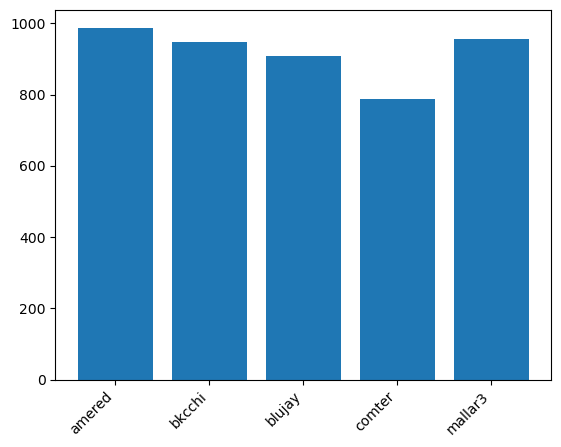

In [ ]:
import matplotlib.pyplot as plt

plt.bar(classes.keys(),classes.values())
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1/255.0,
    validation_split = 0.3,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2, 
        shear_range=0.2,
        zoom_range=0.2, 
        horizontal_flip=True, 
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(
        rescale=1/255.0,
    validation_split = 0.3
)

In [ ]:
train_ds = train_datagen.flow_from_directory(
    directory=data_path,
    subset = "training",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    shuffle=True
)

valid_ds = train_datagen.flow_from_directory(
    directory=data_path,
    subset = "validation",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    shuffle=True
)

Found 3213 images belonging to 5 classes.
Found 1374 images belonging to 5 classes.


In [ ]:
train_ds.class_indices

{'amered': 0, 'bkcchi': 1, 'blujay': 2, 'comter': 3, 'mallar3': 4}

In [ ]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(train_ds.classes), 
            y=train_ds.classes)

print(class_weights)

train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

[0.92861272 0.96777108 1.01037736 1.16624319 0.95910448]
{0: 0.9286127167630058, 1: 0.9677710843373494, 2: 1.010377358490566, 3: 1.1662431941923774, 4: 0.9591044776119403}


In [ ]:
import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger

chk_path = 'bird_resnet50.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

In [ ]:
model = models.Sequential()
model.add(tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None
))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(5,activation="softmax"))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary(
    line_length=None,
    positions=None,
    print_fn=None,
    expand_nested=True,
    show_trainable=False,
    layer_range=None,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 224, 224, 3)]     0         |
|                                                               |
| conv1_pad (ZeroPadding2D)  (None, 230, 230, 3)      0         |
|                                                               |
| conv1_conv (Conv2D)       (None, 112, 112, 64)      9472      |
|                                                               |
| conv1_bn (BatchNormalizatio  (None, 112, 112, 64)   256       |
| n)                                                            |
|                                                               |
| conv1_relu (Activation)   (None, 112, 112, 64)      0         |
|                                                       

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=False), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy','AUC'])

In [ ]:
steps_per_epoch = train_ds.n // train_ds.batch_size
validation_steps = valid_ds.n // valid_ds.batch_size

history = model.fit(x=train_ds,
                 validation_data=valid_ds,
                 epochs=100,
                 callbacks=callbacks,
                 class_weight=train_class_weights,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 1.5370 - accuracy: 0.4036 - auc: 0.7099
Epoch 1: val_loss improved from inf to 1.96140, saving model to bird_resnet50.h5
25/25 [==============================] - 156s 4s/step - loss: 1.5370 - accuracy: 0.4036 - auc: 0.7099 - val_loss: 1.9614 - val_accuracy: 0.2031 - val_auc: 0.5013 - lr: 1.0000e-05
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.5984 - auc: 0.8612
Epoch 2: val_loss improved from 1.96140 to 1.84032, saving model to bird_resnet50.h5
25/25 [==============================] - 86s 3s/step - loss: 1.0525 - accuracy: 0.5984 - auc: 0.8612 - val_loss: 1.8403 - val_accuracy: 0.2094 - val_auc: 0.5198 - lr: 1.0000e-05
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.8747 - accuracy: 0.6658 - auc: 0.9041
Epoch 3: val_loss did not improve from 1.84032
25/25 [==============================] - 101s 4s/step - loss: 0.8747 - accuracy: 0.6658 - auc: 0.9041 -

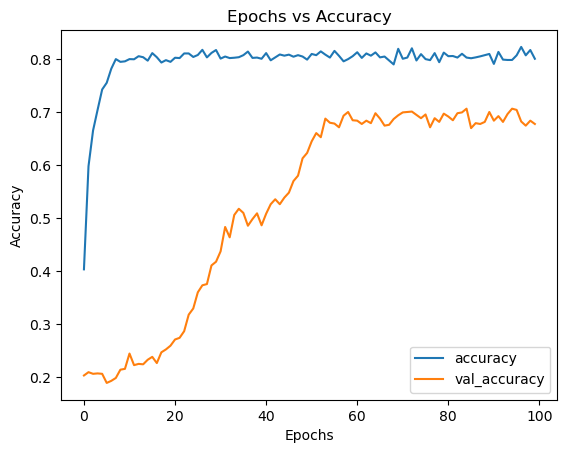

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(history.history['accuracy'],label="accuracy")
plt.plot(history.history['val_accuracy'],label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Epochs vs Accuracy")
plt.show()

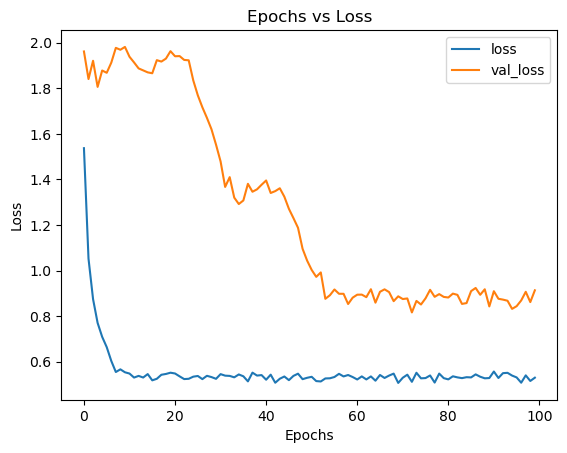

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Epochs vs Loss")
plt.show()

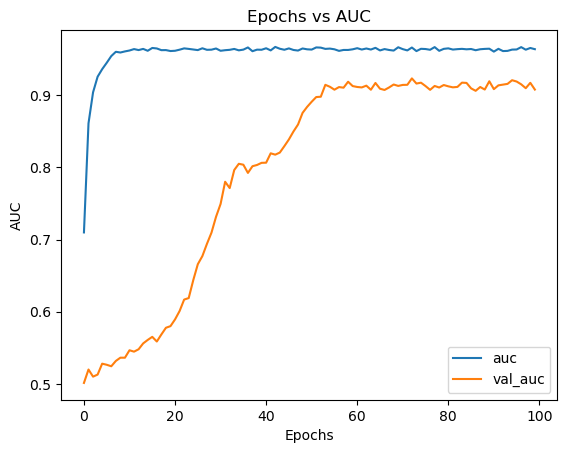

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(history.history['auc'],label="auc")
plt.plot(history.history['val_auc'],label="val_auc")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.title("Epochs vs AUC")
plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/kaggle/working/bird_resnet50.h5')

In [ ]:
model.evaluate(
    x=valid_ds,
    batch_size=None,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False
)

11/11 [==============================] - 27s 2s/step - loss: 0.8745 - accuracy: 0.6936 - auc: 0.9153


[0.8745236396789551, 0.6935953497886658, 0.9152936339378357]

In [ ]:
true_class = valid_ds.classes

In [ ]:
pred = model.predict(valid_ds)

11/11 [==============================] - 24s 2s/step


In [ ]:
import numpy as np
pred_class = list(map(lambda x:x.argmax(),pred))
print(pred_class)

[4, 0, 3, 4, 0, 4, 2, 1, 0, 1, 2, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 4, 3, 3, 1, 1, 4, 2, 2, 1, 0, 3, 4, 4, 2, 0, 4, 2, 0, 3, 0, 0, 0, 4, 4, 3, 0, 4, 2, 2, 0, 1, 1, 1, 2, 4, 3, 2, 4, 0, 1, 4, 0, 1, 4, 4, 2, 2, 3, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 4, 1, 0, 0, 1, 1, 0, 4, 4, 4, 0, 3, 4, 0, 4, 1, 4, 3, 1, 1, 4, 1, 0, 2, 3, 0, 0, 1, 1, 0, 1, 0, 3, 1, 1, 3, 0, 1, 3, 1, 2, 0, 3, 2, 4, 1, 4, 2, 4, 2, 0, 0, 3, 2, 2, 0, 3, 0, 0, 1, 3, 1, 3, 3, 1, 1, 1, 0, 3, 3, 3, 3, 3, 1, 4, 3, 3, 2, 1, 3, 3, 4, 3, 2, 0, 2, 2, 4, 0, 2, 4, 3, 4, 3, 0, 4, 2, 3, 3, 0, 0, 0, 0, 4, 3, 1, 1, 3, 0, 0, 2, 4, 1, 0, 3, 0, 3, 3, 1, 2, 3, 0, 3, 3, 3, 0, 0, 2, 1, 2, 4, 0, 1, 1, 0, 4, 4, 3, 3, 0, 3, 1, 0, 0, 4, 3, 1, 4, 0, 2, 2, 3, 4, 0, 3, 0, 3, 3, 2, 2, 1, 0, 3, 4, 2, 0, 2, 0, 1, 2, 1, 1, 1, 3, 4, 1, 2, 2, 0, 2, 4, 3, 0, 3, 3, 2, 1, 4, 1, 3, 3, 2, 0, 2, 0, 0, 3, 0, 3, 3, 3, 1, 1, 2, 0, 1, 3, 2, 3, 3, 2, 3, 1, 0, 4, 2, 0, 0, 4, 3, 0, 0, 1, 3, 4, 3, 0, 3, 2, 4, 3, 0, 2, 0, 2, 1, 0, 4, 4, 4, 0, 1, 2, 4, 4, 3, 2, 4, 4, 4, 3, 0, 

In [ ]:
from sklearn import metrics

print('Accuracy :',metrics.accuracy_score(true_class,pred_class))

Accuracy : 0.21397379912663755


In [ ]:
print(metrics.classification_report(true_class,pred_class))

              precision    recall  f1-score   support

           0       0.25      0.25      0.25       296
           1       0.19      0.18      0.18       284
           2       0.19      0.17      0.18       272
           3       0.21      0.27      0.23       236
           4       0.23      0.21      0.22       286

    accuracy                           0.21      1374
   macro avg       0.21      0.22      0.21      1374
weighted avg       0.21      0.21      0.21      1374



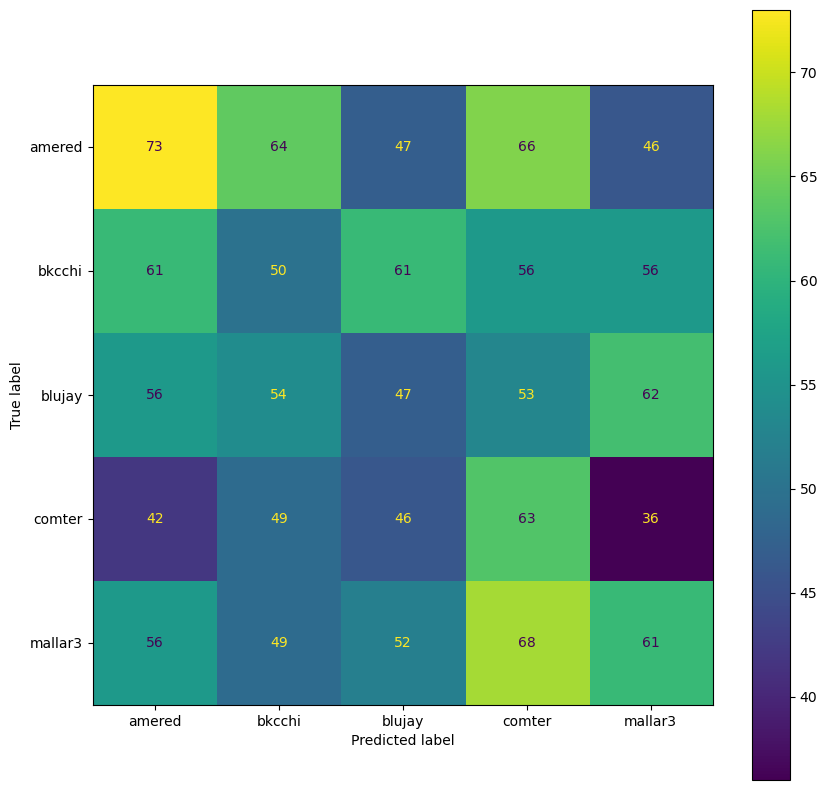

In [ ]:
import os
import matplotlib.pyplot as plt 

cm = metrics.confusion_matrix(true_class, pred_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = sorted(os.listdir(data_path)))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()